In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
def sizeof_fmt(num,suffix='B'):
    for unit in ['','Ki','Mi','Gi', 'Ti', 'Pi','Ei','Zi']:
        if abs(num)<1024.0:
            return "%3.1f %s%s" %(num, unit, suffix)
        num/=1024.0
    return "%.1f%s%s" %(num, 'Yi', suffix)
for d in devices:
    t=d.device_type
    name=d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len (x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro RTX 6000 || GPU || 21.3 GiB


In [2]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [22]:
def CstmNet_2(input_shape=(128, 128, 64, 1)):

    X1_input = Input(input_shape)
    X2_input = Input(input_shape)
    
############ First input branch ######################

    X1 = Conv3D(32, (9, 9, 9), strides=1, name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1_input)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(6, strides=6)(X1) 
    
    X1 = Conv3D(32, (6, 6, 6), strides=1, name='conv2', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=3)(X1) 


    X1 = Conv3D(16, (3, 3, 3), strides=1, name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
    X1 = BatchNormalization(axis=-1)(X1)
    X1 = Activation('relu')(X1)
    X1 = MaxPooling3D(3, strides=2)(X1)   
      
        
############ Second input branch ######################

    X2 = Conv3D(32, (9, 9, 9), strides=1, name='conv3_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2_input)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(6, strides=6)(X2) 
    
    X2 = Conv3D(32, (6, 6, 6), strides=1, name='conv2_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(3, strides=3)(X2) 

    X2 = Conv3D(16, (3, 3, 3), strides=1, name='conv1_1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X2)
    X2 = BatchNormalization(axis=-1)(X2)
    X2 = Activation('relu')(X2)
    X2 = MaxPooling3D(3, strides=2)(X2)     

    
########## Concatenation layer to concatenate the two inputs prior to dense layers to calculate outputs ########
    final_concat = concatenate([X1, X2])

    X = Flatten()(final_concat)
    
############ Final Layer ######################
    
    X = Dense(512, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.1)(X)
    X = Dense(256, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.1)(X)
    X = Dense(128, activation='relu', name='fc3', kernel_initializer=glorot_uniform(seed=0))(X)
    drop = Dropout(0.1)(X)
    output = Dense(3, activation='softmax', name='fc5',kernel_initializer=glorot_uniform(seed=0))(drop) 
    model = Model(inputs=[X1_input, X2_input], outputs=output, name='CstmNet_2')
    
    return model

model = CstmNet_2(input_shape=(128, 128, 64, 1))
model.summary()

Model: "CstmNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
conv3 (Conv3D)                  (None, 128, 128, 64, 23360       input_1[0][0]                    
__________________________________________________________________________________________________
conv3_1 (Conv3D)                (None, 128, 128, 64, 23360       input_2[0][0]                    
__________________________________________________________________________________________

In [23]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

##extract the image array and class name
img_train1, class_train1 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_edema\\train')
img_train2, class_train2 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_edema_LYM\\train')
img_val, class_val =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_edema\\val')
#img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_edema\\test')

img_train3, class_train3 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_enh\\train')
img_train4, class_train4 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_enh_LYM\\train')
img_val2, class_val2 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_enh\\val')
#img_test2, class_test2 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_enh\\test')

####################################################################################################

target_dict1={k: v for v, k in enumerate(np.unique(class_train1))}
target_val1=  [target_dict1[class_train1[i]] for i in range(len(class_train1))]
print(target_dict1)

target_dict2={k: v for v, k in enumerate(np.unique(class_train2))}
target_val2=  [target_dict2[class_train2[i]] for i in range(len(class_train2))]
print(target_dict2)

target_dict_val={k: v for v, k in enumerate(np.unique(class_val))}
target_val_val=  [target_dict_val[class_val[i]] for i in range(len(class_val))]
print(target_dict_val)

# target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
# target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
# print(target_dict_test)

#######################################################################################################

target_dict3={k: v for v, k in enumerate(np.unique(class_train3))}
target_val3=  [target_dict1[class_train3[i]] for i in range(len(class_train3))]
print(target_dict3)

target_dict4={k: v for v, k in enumerate(np.unique(class_train4))}
target_val4=  [target_dict4[class_train4[i]] for i in range(len(class_train4))]
print(target_dict4)

target_dict_val2={k: v for v, k in enumerate(np.unique(class_val2))}
target_val_val2=  [target_dict_val2[class_val2[i]] for i in range(len(class_val2))]
print(target_dict_val2)

# target_dict_test2={k: v for v, k in enumerate(np.unique(class_test2))}
# target_val_test2=  [target_dict_test2[class_test2[i]] for i in range(len(class_test2))]
# print(target_dict_test2)

#######################################################################################################
## F only tumor Shape
# For Training Set ##
x1=np.array(img_train1, np.float32)
y_train1=np.array(list(map(int,target_val1)), np.float32)
X_train1 = np.expand_dims(x1, axis=4)
# LYM
x2=np.array(img_train2, np.float32)
y_train2=np.array(list(map(int,target_val2)), np.float32)
X_train2 = np.expand_dims(x2, axis=4)

## For Validation Set ##
x_val=np.array(img_val, np.float32)
y_val=np.array(list(map(int,target_val_val)), np.float32)
X_val = np.expand_dims(x_val, axis=4)

## For Test Set ###
# x_test=np.array(img_test, np.float32)
# y_test=np.array(list(map(int,target_val_test)), np.float32)
# X_test = np.expand_dims(x_test, axis=4)

## F brain shape 
## For Training Set ##
x3=np.array(img_train3, np.float32)
y_train3=np.array(list(map(int,target_val3)), np.float32)
X_train3 = np.expand_dims(x3, axis=4)
# LYM
x4=np.array(img_train4, np.float32)
y_train4=np.array(list(map(int,target_val4)), np.float32)
X_train4 = np.expand_dims(x4, axis=4)

## For Validation Set ##
x_val2=np.array(img_val2, np.float32)
y_val2=np.array(list(map(int,target_val_val2)), np.float32)
X_val2 = np.expand_dims(x_val2, axis=4)

## For Test Set ###
# x_test2=np.array(img_test2, np.float32)
# y_test2=np.array(list(map(int,target_val_test2)), np.float32)
# X_test2 = np.expand_dims(x_test2, axis=4)


print("################ tumor only shapes #####################")

print(X_train1.shape)
print(y_train1.shape)
print(X_train2.shape)
print(y_train2.shape)

print(X_val.shape)
print(y_val.shape)

#print(X_test.shape)
#print(y_test.shape)

print("############## tumor only shapes ############################")

print(X_train3.shape)
print(y_train3.shape)
print(X_train4.shape)
print(y_train4.shape)

print(X_val2.shape)
print(y_val2.shape)

#print(X_test2.shape)
#print(y_test2.shape)

{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
################ tumor only shapes #####################
(299, 128, 128, 64, 1)
(299,)
(47, 128, 128, 64, 1)
(47,)
(47, 128, 128, 64, 1)
(47,)
############## tumor only shapes ############################
(299, 128, 128, 64, 1)
(299,)
(47, 128, 128, 64, 1)
(47,)
(47, 128, 128, 64, 1)
(47,)


In [3]:
import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name

img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_edema\\test')
img_test2, class_test2 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh\\Class_enh\\test')

####################################################################################################

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

#######################################################################################################

target_dict_test2={k: v for v, k in enumerate(np.unique(class_test2))}
target_val_test2=  [target_dict_test2[class_test2[i]] for i in range(len(class_test2))]
print(target_dict_test2)

#######################################################################################################
### Ede_F tumor Shape
## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

## Enh_CE tumor shape 
## For Test Set ###
x_test2=np.array(img_test2, np.float32)
y_test2=np.array(list(map(int,target_val_test2)), np.float32)
X_test2 = np.expand_dims(x_test2, axis=4)

print("################ Ede_F tumor shapes #####################")
print(X_test.shape)
print(y_test.shape)

print("############## Enh_CE tumor Shapes ############################")
print(X_test2.shape)
print(y_test2.shape)

{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
################ Ede_F tumor shapes #####################
(96, 128, 128, 64, 1)
(96,)
############## Enh_CE tumor Shapes ############################
(96, 128, 128, 64, 1)
(96,)


In [3]:
### External Validation Dataset ########


import nibabel as nib
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image = nib.load(image_path)
            img = image.get_fdata()
            img = zoom(img, (0.533, 0.533, 0.413)) 
            img [img<0] = 0
            img_nor = img / np.max(img)
            img_nor = img_nor.astype(np.float32)
            
            img_data_array.append(img_nor)
            class_name.append(dir1)
    return img_data_array, class_name

# extract the image array and class name

img_test, class_test =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh_external\\Class_edema')
img_test2, class_test2 =create_dataset(r'C:\\Dhruba Research Drive\\edem_enh_external\\Class_enh')

####################################################################################################

target_dict_test={k: v for v, k in enumerate(np.unique(class_test))}
target_val_test=  [target_dict_test[class_test[i]] for i in range(len(class_test))]
print(target_dict_test)

#######################################################################################################

target_dict_test2={k: v for v, k in enumerate(np.unique(class_test2))}
target_val_test2=  [target_dict_test2[class_test2[i]] for i in range(len(class_test2))]
print(target_dict_test2)

#######################################################################################################
### Ede_F tumor Shape
## For Test Set ###
x_test=np.array(img_test, np.float32)
y_test=np.array(list(map(int,target_val_test)), np.float32)
X_test = np.expand_dims(x_test, axis=4)

## Enh_CE tumor shape 
## For Test Set ###
x_test2=np.array(img_test2, np.float32)
y_test2=np.array(list(map(int,target_val_test2)), np.float32)
X_test2 = np.expand_dims(x_test2, axis=4)

print("################ Ede_F tumor shapes #####################")
print(X_test.shape)
print(y_test.shape)

print("############## Enh_CE tumor Shapes ############################")
print(X_test2.shape)
print(y_test2.shape)

{'GBM': 0, 'LYM': 1, 'Mets': 2}
{'GBM': 0, 'LYM': 1, 'Mets': 2}
################ Ede_F tumor shapes #####################
(47, 128, 128, 64, 1)
(47,)
############## Enh_CE tumor Shapes ############################
(47, 128, 128, 64, 1)
(47,)


In [24]:
from scipy import ndimage
img_aug_array=[]
class_aug_array = []
angles = np.arange(-5, 6, 5)
for d in range (y_train2.shape[0]):
    for e in range (3):
            volume = ndimage.rotate(img_train2[d], angles[e], reshape=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train2[d]
            class_aug_array.append(y_train_class)

X_train_aug2 = np.array(img_aug_array, np.float32)
X_train_aug2 = np.expand_dims(X_train_aug2, axis=4)
print(X_train_aug2.shape)

y_train_aug2 = np.array(class_aug_array, np.float32)
print(y_train_aug2.shape)

img_aug_array=[]
class_aug_array = []
angles = np.arange(-5, 6, 5)
for d in range (y_train4.shape[0]):
    for e in range (3):
            volume = ndimage.rotate(img_train4[d], angles[e], reshape=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train4[d]
            class_aug_array.append(y_train_class)

X_train_aug2_2 = np.array(img_aug_array, np.float32)
X_train_aug2_2 = np.expand_dims(X_train_aug2_2, axis=4)
print(X_train_aug2_2.shape)

y_train_aug2_2 = np.array(class_aug_array, np.float32)
print(y_train_aug2_2.shape)

(141, 128, 128, 64, 1)
(141,)
(141, 128, 128, 64, 1)
(141,)


In [25]:
X_train1 = np.concatenate((X_train1, X_train_aug2), axis=0)
print(X_train1.shape)
X_train2 = np.concatenate((X_train3, X_train_aug2_2), axis=0)
print(X_train2.shape)

y_train1 = np.concatenate((y_train1, y_train_aug2), axis=0)
print(y_train1.shape)
y_train2 = np.concatenate((y_train3, y_train_aug2_2), axis=0)
print(y_train2.shape)

(440, 128, 128, 64, 1)
(440, 128, 128, 64, 1)
(440,)
(440,)


In [26]:
import scipy

def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 3

    height, width, depth= image.shape
    zheight             = int(np.round(factor * height))
    zwidth              = int(np.round(factor * width))
    zdepth              = depth

    if factor < 1.0:
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        layer   = (depth - zdepth) // 2
        newimg[row:row+zheight, col:col+zwidth, layer:layer+zdepth] = scipy.ndimage.interpolation.zoom(image, (float(factor), float(factor), 1.0), order=order, mode='nearest')[0:zheight, 0:zwidth, 0:zdepth]

        return newimg

    elif factor > 1.0:
        row     = (zheight - height) // 2
        col     = (zwidth - width) // 2
        layer   = (zdepth - depth) // 2

        newimg = scipy.ndimage.interpolation.zoom(image[row:row+zheight, col:col+zwidth, layer:layer+zdepth], (float(factor), float(factor), 1.0), order=order, mode='nearest')  
        
        extrah = (newimg.shape[0] - height) // 2
        extraw = (newimg.shape[1] - width) // 2
        extrad = (newimg.shape[2] - depth) // 2
        newimg = newimg[extrah:extrah+height, extraw:extraw+width, extrad:extrad+depth]

        return newimg

    else:
        return image
    
################################ CE  ######################################

img_aug_array=[]
class_aug_array = []
zoom = [0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
for d in range (y_train1.shape[0]):
    for e in range (6):
            volume = scaleit(X_train1[d, :, :, :, 0], zoom[e], isseg=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train1[d]
            class_aug_array.append(y_train_class)
        
X_train_aug1_2 = np.array(img_aug_array, np.float32)
X_train_aug1_2 = np.expand_dims(X_train_aug1_2, axis=4)
print(X_train_aug1_2.shape)

y_train_aug1_2 = np.array(class_aug_array, np.float32)
print(y_train_aug1_2.shape)

################################ T2  ######################################

img_aug_array=[]
class_aug_array = []
zoom = [0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
for d in range (y_train2.shape[0]):
    for e in range (6):
            volume = scaleit(X_train2[d, :, :, :, 0], zoom[e], isseg=False)
            img_aug_array.append(volume)
            
            y_train_class = y_train2[d]
            class_aug_array.append(y_train_class)
        
X_train_aug2_2 = np.array(img_aug_array, np.float32)
X_train_aug2_2 = np.expand_dims(X_train_aug2_2, axis=4)
print(X_train_aug2_2.shape)

y_train_aug2_2 = np.array(class_aug_array, np.float32)
print(y_train_aug2_2.shape)

(2640, 128, 128, 64, 1)
(2640,)
(2640, 128, 128, 64, 1)
(2640,)


In [27]:
X_train_f1 = X_train_aug1_2[:, ::-1, :]
y_train_f1 = y_train_aug1_2

X_train_aug1 = np.concatenate((X_train_aug1_2, X_train_f1), axis=0)
print(X_train_aug1.shape)
y_train_aug1 = np.concatenate((y_train_aug1_2, y_train_f1), axis=0)
print(y_train_aug1.shape)

X_train_f2 = X_train_aug2_2[:, ::-1, :]
y_train_f2 = y_train_aug2_2

X_train_aug2 = np.concatenate((X_train_aug2_2, X_train_f2), axis=0)
print(X_train_aug2.shape)
y_train_aug2 = np.concatenate((y_train_aug2_2, y_train_f2), axis=0)
print(y_train_aug2.shape)

(5280, 128, 128, 64, 1)
(5280,)
(5280, 128, 128, 64, 1)
(5280,)


In [28]:
y_train_enc1 = to_categorical(y_train_aug1)
y_test_enc1 = to_categorical (y_test)
y_val_enc1 = to_categorical (y_val)
print(y_val)
############################################################
y_train_enc2 = to_categorical(y_train_aug2)
y_test_enc2 = to_categorical (y_test2)
y_val_enc2 = to_categorical (y_val2)
print(y_val2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [4]:
y_test_enc1 = to_categorical (y_test)
y_test_enc2 = to_categorical (y_test2)

In [30]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


filepath = 'exter_CstmNt2_edeF_enhCE_3class.epoch{epoch:02d}-acc{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=False,
                             mode='max')
callbacks = [checkpoint]

#for Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=6e-4,
    decay_steps=10000,
    decay_rate=0.9)

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results=model.fit(
          x=[X_train_aug1, X_train_aug2],
          y=[y_train_enc1],
          validation_data = ([X_test, X_test2], y_test_enc1),
          epochs = 15,
          batch_size = 10,
          callbacks=callbacks)

Train on 5280 samples, validate on 85 samples
Epoch 1/15
5280/5280 [==============================] - ETA: 0s - loss: 0.2944 - acc: 0.8894
Epoch 00001: saving model to exter_CstmNt2_edeF_enhCE_3class.epoch01-acc0.52.hdf5
5280/5280 [==============================] - 473s 89ms/sample - loss: 0.2944 - acc: 0.8894 - val_loss: 1.8602 - val_acc: 0.5176
Epoch 2/15
5280/5280 [==============================] - ETA: 0s - loss: 0.1263 - acc: 0.9555
Epoch 00002: saving model to exter_CstmNt2_edeF_enhCE_3class.epoch02-acc0.69.hdf5
5280/5280 [==============================] - 468s 89ms/sample - loss: 0.1263 - acc: 0.9555 - val_loss: 1.3415 - val_acc: 0.6941
Epoch 3/15
5280/5280 [==============================] - ETA: 0s - loss: 0.0756 - acc: 0.9729
Epoch 00003: saving model to exter_CstmNt2_edeF_enhCE_3class.epoch03-acc0.60.hdf5
5280/5280 [==============================] - 458s 87ms/sample - loss: 0.0756 - acc: 0.9729 - val_loss: 1.8336 - val_acc: 0.6000
Epoch 4/15
5280/5280 [=======================

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


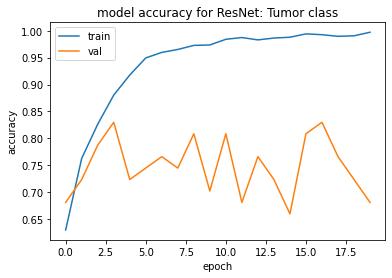

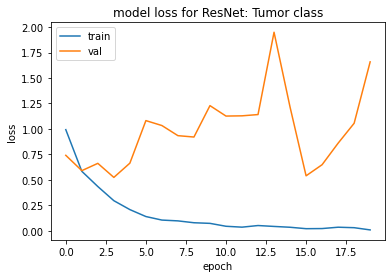

In [62]:
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy for ResNet: Tumor class')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss for ResNet: Tumor class')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
classification_model = load_model('fold1_CstmNt2_edeF_enhCE_3class.epoch03-acc0.78.hdf5', compile = False)

In [6]:
from sklearn.metrics import accuracy_score

y_pred = classification_model.predict(x=[X_test, X_test2], batch_size = 20)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test_enc1[i]))
    
a = accuracy_score(test, pred)
print('Accuracy is:', a*100)

C:\Users\dhruba\.conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy is: 100.0


In [47]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def top_2_categorical_accuracy(y_test_enc1, y_pred):
    return top_k_categorical_accuracy(y_test_enc1, y_pred, k=2)
m = top_k_categorical_accuracy(y_test_enc1, y_pred, k=2)

with tf.Session() as sess:  print(sum(m.eval())/np.shape(y_test)[0]*100)

100.0


In [7]:
y_pred

array([[9.89897966e-01, 8.42756650e-04, 9.25927982e-03],
       [9.88406181e-01, 5.82554331e-03, 5.76837966e-03],
       [9.93992388e-01, 7.64973302e-05, 5.93110174e-03],
       [9.92060423e-01, 1.48529676e-03, 6.45436998e-03],
       [9.91002679e-01, 1.02492992e-03, 7.97239691e-03],
       [9.99550998e-01, 6.72490205e-05, 3.81801685e-04],
       [9.96666133e-01, 1.00926822e-03, 2.32457253e-03],
       [9.99031067e-01, 3.78343771e-04, 5.90620330e-04],
       [9.98449206e-01, 4.57427523e-04, 1.09330565e-03],
       [9.88225222e-01, 6.78912876e-03, 4.98563889e-03],
       [9.83249426e-01, 8.26408342e-03, 8.48658942e-03],
       [9.76622462e-01, 5.17193752e-04, 2.28603911e-02],
       [9.96514618e-01, 2.29879562e-03, 1.18664780e-03],
       [9.98903871e-01, 4.11504530e-04, 6.84613013e-04],
       [9.99722421e-01, 7.35206686e-06, 2.70117132e-04],
       [9.96290088e-01, 2.39101471e-04, 3.47083528e-03],
       [9.91609991e-01, 3.24896909e-03, 5.14101330e-03],
       [9.80386436e-01, 4.52113

In [39]:
y_test_enc1

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float3

In [40]:
print('Ground Truth for external Validation set:')
print(test)
print('Prediction for external Validation set:')
print(pred)

Ground Truth for external Validation set:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Prediction for external Validation set:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [42]:
y_pred_int = np.argmax(y_pred, axis=1) 
y_pred_int.dtype

dtype('int64')

In [43]:
y_test = y_test.astype(np.int64)
y_test.dtype

dtype('int64')

In [44]:
from sklearn.metrics import classification_report

target_names = ['GBM', 'LYM', 'Mets']
print(classification_report(y_test, y_pred_int, target_names=target_names))

              precision    recall  f1-score   support

         GBM       1.00      1.00      1.00        20
         LYM       1.00      1.00      1.00         6
        Mets       1.00      1.00      1.00        21

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47

